In [1]:
import tensorflow as tf
from tensorflow import keras

2026-02-14 13:44:51.286466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771076691.462856      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771076691.513018      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771076691.909087      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771076691.909123      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771076691.909126      55 computation_placer.cc:177] computation placer alr

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aarishasifkhan/plantvillage-potato-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/aarishasifkhan/plantvillage-potato-disease-dataset


In [3]:
import os
file_path=os.path.join(path,'PlantVillage')
print(file_path)
tf_dataset=tf.keras.preprocessing.image_dataset_from_directory(file_path,batch_size=32,shuffle=True,image_size=(256,256))

/kaggle/input/datasets/aarishasifkhan/plantvillage-potato-disease-dataset/PlantVillage
Found 2152 files belonging to 3 classes.


I0000 00:00:1771076707.326064      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771076707.332200      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
for i ,j in tf_dataset.take(1):
    print(i.numpy())
    print(j.numpy())

[[[[183. 169. 169.]
   [159. 145. 145.]
   [146. 132. 132.]
   ...
   [133. 108. 111.]
   [145. 120. 123.]
   [117.  92.  95.]]

  [[158. 144. 144.]
   [154. 140. 140.]
   [150. 136. 136.]
   ...
   [115.  90.  93.]
   [126. 101. 104.]
   [123.  98. 101.]]

  [[151. 137. 137.]
   [158. 144. 144.]
   [155. 141. 141.]
   ...
   [114.  89.  92.]
   [125. 100. 103.]
   [155. 130. 133.]]

  ...

  [[195. 184. 182.]
   [177. 166. 164.]
   [182. 171. 169.]
   ...
   [133. 109. 109.]
   [ 88.  64.  64.]
   [168. 144. 144.]]

  [[182. 171. 169.]
   [161. 150. 148.]
   [194. 183. 181.]
   ...
   [137. 113. 113.]
   [172. 148. 148.]
   [173. 149. 149.]]

  [[193. 182. 180.]
   [159. 148. 146.]
   [203. 192. 190.]
   ...
   [109.  85.  85.]
   [119.  95.  95.]
   [138. 114. 114.]]]


 [[[206. 188. 184.]
   [206. 188. 184.]
   [203. 185. 181.]
   ...
   [176. 156. 155.]
   [177. 157. 156.]
   [178. 158. 157.]]

  [[194. 176. 172.]
   [195. 177. 173.]
   [194. 176. 172.]
   ...
   [172. 152. 151.]
 

In [5]:
class_names = tf_dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [6]:
#why the length is 68
len(tf_dataset)

68

In [7]:
32*68

2176

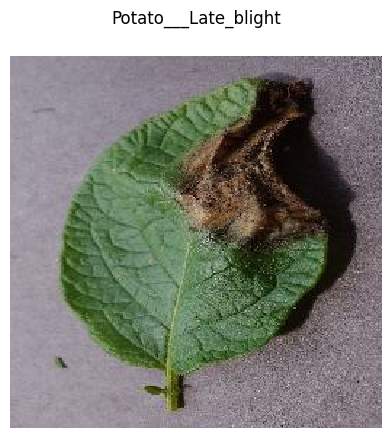

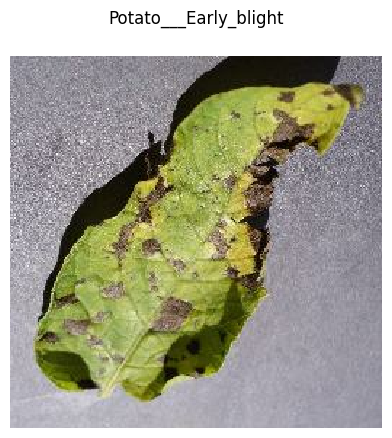

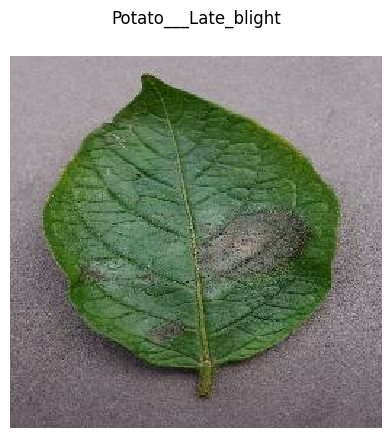

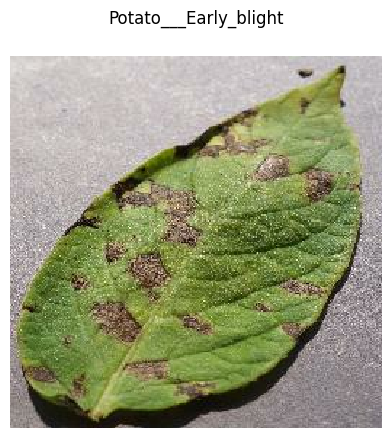

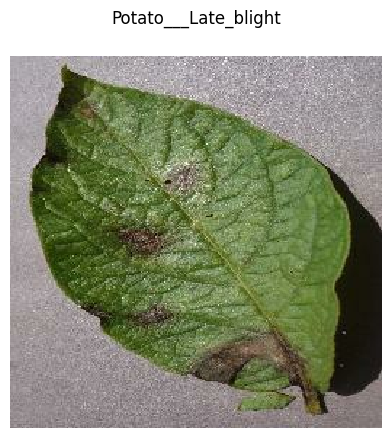

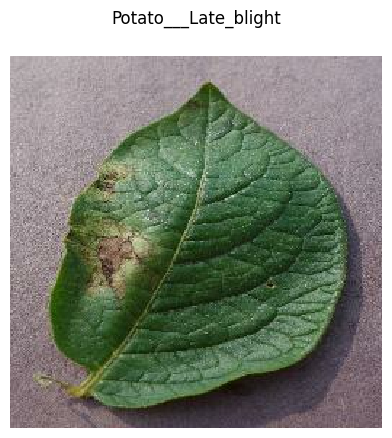

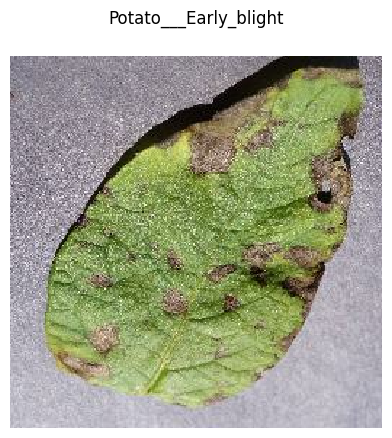

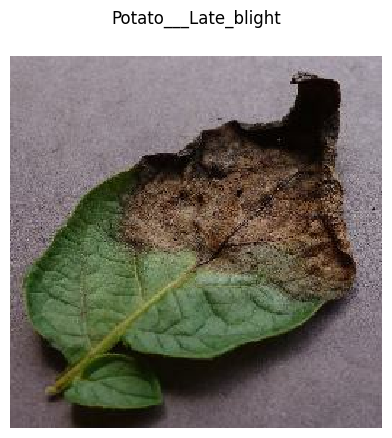

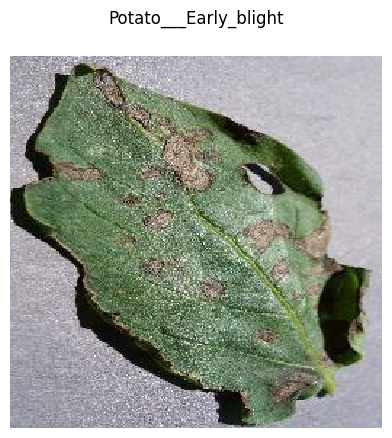

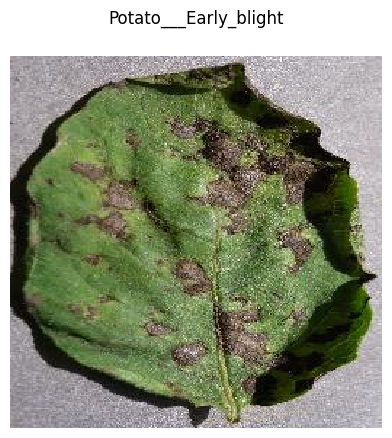

In [30]:
import matplotlib.pyplot as plt

for i,j in tf_dataset.take(1):
    for l in range(10):
        plt.matshow(i[l].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[j[l]])

In [31]:
#now we want to make  our train and test split
len(tf_dataset)

68

In [32]:
68*0.8

54.400000000000006

In [33]:
train_ds=tf_dataset.take(int(len(tf_dataset)*0.8))

In [34]:
len(train_ds)

54

In [35]:
test_ds=tf_dataset.skip(int(len(tf_dataset)*0.8))

In [36]:
len(test_ds)

14

In [38]:
#i will find out the validatiuon_data of our and as well as the testing data
validation_ds=test_ds.take(int(len(test_ds)*0.5))
final_test_ds=test_ds.skip(int(len(test_ds)*0.5))

In [40]:
print(len(train_ds))
print(len(test_ds))
print(len(validation_ds))
print(len(final_test_ds))

54
14
7
7


In [41]:
train_ds=train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_ds=validation_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
final_test_ds=final_test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [42]:
#so we will do the resizing and rescaling so that for any image the model will see from the outside model should be able to answe
resize_and_rescale=tf.keras.Sequential([
    keras.layers.Resizing(256,256,input_shape=(256,256,3)),
    keras.layers.Rescaling(1./255)
])

In [43]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1) # Standard practice to provide a zoom range
])

In [44]:
model=keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    keras.layers.Conv2D(128,3,padding="same",activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(80,3,padding="same",activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64,3,padding="same",activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32,3,padding="same",activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(132,activation="relu"),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(32,activation="relu"),
    
    keras.layers.Dense(3,activation="softmax")
])

In [45]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 80)   │        92,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        46,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 132)            │     1,081,476 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,252,599 (4.78 MB)

 Trainable params: 1,252,599 (4.78 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Watch the validation error
    patience=5,             # Wait 5 epochs for improvement before quitting
    restore_best_weights=True # Keep the best version, not the last one
)

In [47]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history=model.fit(train_ds,validation_data=validation_ds,epochs=15,callbacks=early_stopping)


Epoch 1/15


E0000 00:00:1771077344.537869      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - accuracy: 0.4367 - loss: 0.9711 - val_accuracy: 0.4464 - val_loss: 0.8814
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.5915 - loss: 0.7672 - val_accuracy: 0.7991 - val_loss: 0.5324
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step - accuracy: 0.8097 - loss: 0.4970 - val_accuracy: 0.8438 - val_loss: 0.4047
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.8484 - loss: 0.3785 - val_accuracy: 0.8259 - val_loss: 0.5310
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 310ms/step - accuracy: 0.8652 - loss: 0.3453 - val_accuracy: 0.8125 - val_loss: 0.7177
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step - accuracy: 0.9119 - loss: 0.2248 - val_accuracy: 0.8973 - val_loss: 0.5262
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.9505 - loss: 0.1475 - val_accuracy: 0.9286 - val_loss: 0.2162
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.9444 - loss: 0.1486 - val_accuracy: 0.950

In [48]:
print(history.params)

{'verbose': 'auto', 'epochs': 15, 'steps': 54}


In [49]:
scores=model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9657 - loss: 0.0718


In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [50]:
acc=history.history["accuracy"]
loss=history.history["loss"]
val_acc=history.history["val_accuracy"]
val_loss=history.history["val_loss"]

In [51]:
print(acc)
print(loss)
print(val_acc)
print(val_loss)

[0.46759259700775146, 0.6875, 0.8321759104728699, 0.8605324029922485, 0.8813657164573669, 0.9155092835426331, 0.9363425970077515, 0.9432870149612427, 0.9363425970077515, 0.9589120149612427, 0.9554398059844971, 0.9548611044883728, 0.9646990895271301, 0.9670138955116272, 0.96875]
[0.9250311255455017, 0.6597093939781189, 0.46792587637901306, 0.3752609193325043, 0.29729294776916504, 0.22086897492408752, 0.16857892274856567, 0.15197421610355377, 0.15988494455814362, 0.11353112757205963, 0.11981501430273056, 0.1077837347984314, 0.11071731150150299, 0.08176228404045105, 0.08219445496797562]
[0.4464285671710968, 0.7991071343421936, 0.84375, 0.8258928656578064, 0.8125, 0.8973214030265808, 0.9285714030265808, 0.9508928656578064, 0.875, 0.9241071343421936, 0.9642857313156128, 0.9598214030265808, 0.9330357313156128, 0.9419642686843872, 0.8883928656578064]
[0.8814159035682678, 0.5324125289916992, 0.4046791195869446, 0.5309961438179016, 0.7177419662475586, 0.5261858701705933, 0.2161683887243271, 0.1

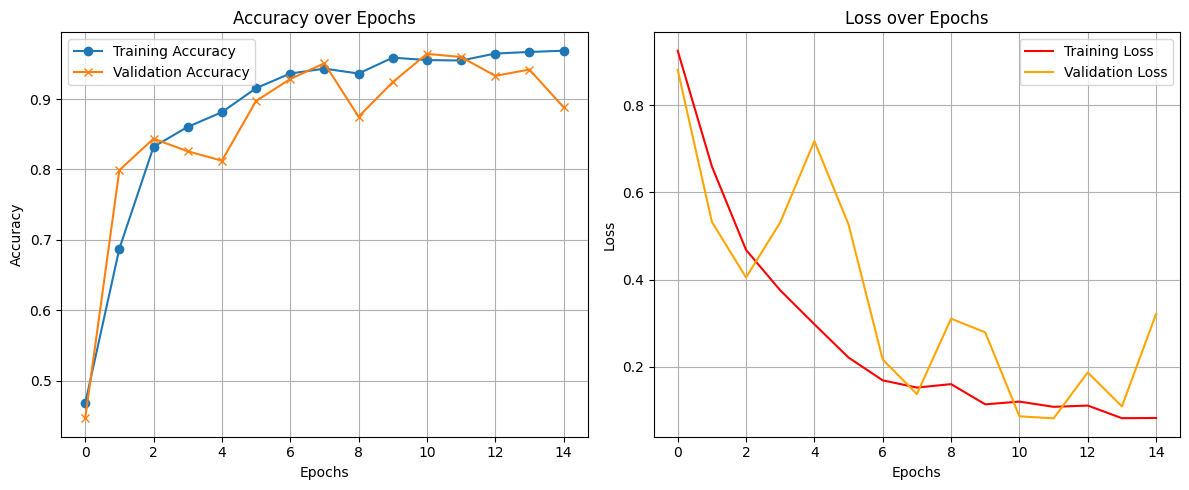

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5)) # Slightly wider for two side-by-side plots

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label="Training Accuracy", marker='o')
plt.plot(range(len(val_acc)), val_acc, label="Validation Accuracy", marker='x')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label="Training Loss", color='red')
plt.plot(range(len(val_loss)), val_loss, label="Validation Loss", color='orange')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout() # Prevents overlapping labels
plt.show()



In [54]:
y_pred=model.predict(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


In [56]:
import numpy as np

In [57]:
y_pred=[np.argmax(i) for i in y_pred]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


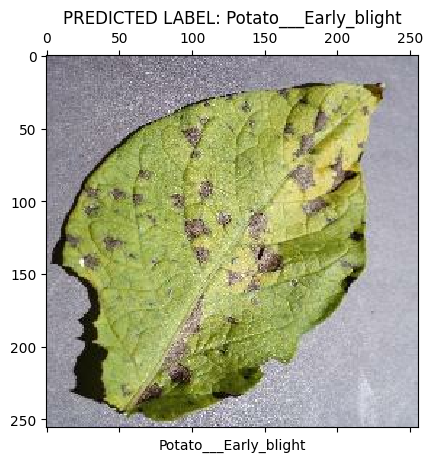

In [60]:
#so for checking what our model has predicted and what should be the prediction 
for image,label in train_ds.take(1):
    image=image[12].numpy()
    label=label[12].numpy()
    plt.matshow(image.astype('uint8'))
    plt.xlabel(class_names[label])

    expand_image=np.expand_dims(image,axis=0)
    pred_label=model.predict(expand_image)
    prediction=np.argmax(pred_label)
    plt.title(f"PREDICTED LABEL: {class_names[prediction]}")

In [61]:
# so i tested this and found out that the model was actaully performing very well 

In [63]:

model_version = 1
# Absolute path (Recommended)
save_path = f"/kaggle/working/model_v{model_version}.h5" 

# Relative path (Works because /kaggle/working is the default)
# save_path = f"model_v{model_version}.h5"

model.save(save_path)

In [64]:
from IPython.display import FileLink
FileLink(r'model_v1.h5')

/kaggle/working/model_v1.h5